In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/WSI_segment_pipeline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/WSI_segment_pipeline


In [2]:
from src.makedata import *
from src.makemodel import *

In [3]:
# load training/testing data
batch = 16
phases=["train","val"]
dataname="dk22"
dataLoader = {}
shuffle = True
for phase in phases:
    dataLoader[phase] = Data_Loader(dataname,phase,batch,shuffle)
    dataset_size = len(dataLoader[phase])
    print('%s images = %d' % (phase, dataset_size))

train images = 1100
val images = 149


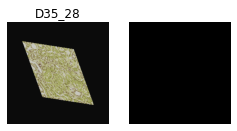

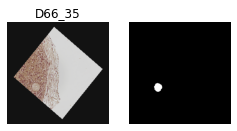

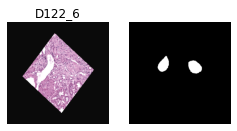

In [4]:
dataLoader["train"].vis_data()

In [5]:
isTrain = True
isContinue = False
savedir = "./log/"
loadpath = ""
num_epochs = 100

In [6]:
# create/load model
model = GlomNet(isTrain, isContinue, savedir, loadpath, "UNet")

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
[CREATE] MODEL


Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/checkpoints/vgg13_bn-abd245e5.pth



UNet
UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

In [7]:
import math,time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [8]:
phases = ["train","val"]
start_time = time.time()
best_loss_on_test = np.Infinity
device = model.get_device()

for epoch in range(num_epochs):
    # accumulate loss for batches
    all_loss = {key: torch.zeros(0).to(device) for key in phases}
    
    for phase in phases:
        if phase == "train":
            model.set_train()  # Set model to training mode
        else: 
            model.set_eval() 
        
        for ii , data in enumerate(dataLoader[phase]): #for each of the batches
            # input training image and mask
            model.set_input(data["img"],data["msk"])

            if phase == "train":
                model.forward()
                model.backward()
            else:
                model.validate() # no_grad, speed up
                
            all_loss[phase]=torch.cat((all_loss[phase],model.get_loss().detach().view(1,-1)))
        
        all_loss[phase] = all_loss[phase].cpu().numpy().mean()

    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
            epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")
    
    # save model with lowest validation loss
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        model.save_networks("dk20_UNet_scl_pre{}*.pth".format(epoch),epoch)
    else:
        print(" ")
    # lr linear decrease
    if ((epoch>=40) and epoch%40==0 and epoch<240):
        model.update_lr()

1m 33s (- 154m 40s) ([1/100] 1%), train loss: 0.1964 test loss: 0.0791  **
2m 13s (- 109m 12s) ([2/100] 2%), train loss: 0.0658 test loss: 0.0507  **


KeyboardInterrupt: ignored